In [1]:
from rsna_retro.imports import *
from rsna_retro.metadata import *
from rsna_retro.preprocess import *
from rsna_retro.train import *
from rsna_retro.train3d import *
from rsna_retro.seutao import *

Loading imports


In [2]:
dbunch = get_seutao_dbunch_meta(Meta.df_comb1, np_file, csv_file, bs=64)

loading features
Done loading features


In [3]:
xb,yb = dbunch.one_batch()

In [4]:
[x.shape for x in xb]

[torch.Size([64, 56, 2048]), torch.Size([64, 56, 6]), torch.Size([64, 56, 1])]

In [5]:
torch.cat(xb, axis=-1).shape

torch.Size([64, 56, 2055])

## Load

In [6]:
class SeqHead(nn.Module):
    def __init__(self):
        super().__init__()
        d_model = 2048+6+1
        hidden = 96
        self.lstm = nn.LSTM(input_size=d_model, hidden_size=hidden, num_layers=2, bidirectional=True)
        self.head = nn.Sequential(nn.Linear(hidden*2,6))
        
    def forward(self, x):
        x = torch.cat(x, axis=-1)
        feat, _ = self.lstm(x.transpose(0,1))
        return self.head(feat.transpose(0,1))

In [7]:
m = SeqHead().cuda()

In [8]:
learn = get_learner(dbunch, m)

In [9]:
name = 'seutao_feat_simple_lstm_meta'

In [10]:
learn.add_cb(DePadLoss())
# learn.add_cb(SaveModelCallback(name))

## Train

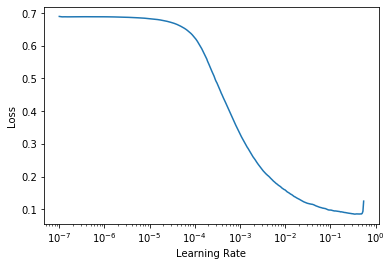

In [15]:
learn.lr_find(num_it=500)

In [16]:
do_fit(learn, 10, 1e-2)
learn.save(f'runs/{name}-1')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.077142,0.068359,0.977607,0.960748,00:16
1,0.062260,0.066904,0.978586,0.961423,00:16
2,0.062497,0.063509,0.978393,0.961127,00:16
3,0.062578,0.063029,0.978484,0.961198,00:16
4,0.059019,0.062008,0.979091,0.961482,00:16
5,0.056254,0.062050,0.979129,0.961589,00:16
6,0.055298,0.060971,0.979233,0.962193,00:16
7,0.053383,0.060573,0.979218,0.961625,00:16
8,0.051392,0.060628,0.979223,0.961814,00:16
9,0.051930,0.060537,0.979237,0.961980,00:16


In [17]:
do_fit(learn, 4, 1e-3)
learn.save(f'runs/{name}-2')

epoch,train_loss,valid_loss,accuracy_multi,accuracy_any,time
0,0.052617,0.060668,0.979009,0.961340,00:16
1,0.051705,0.060676,0.979210,0.961625,00:16
2,0.050453,0.060628,0.979113,0.961471,00:16
3,0.050902,0.060763,0.979091,0.961518,00:16


## Submit

In [11]:
submit_predictions(m, f'runs/{name}-1', f'subm/{name}', 'testing seutao features simple lstm meta included', dfunc=get_seutao_dbunch_meta)

loading features
Done loading features


100%|██████████| 26.0M/26.0M [00:02<00:00, 9.73MB/s]


In [13]:
api.competitions_submissions_list('rsna-intracranial-hemorrhage-detection')[0]

{'ref': 14066229,
 'totalBytes': 27277209,
 'date': '2020-01-07T04:02:14.2Z',
 'description': 'testing seutao features simple lstm meta included',
 'errorDescription': None,
 'fileName': 'seutao_feat_simple_lstm_meta.csv',
 'publicScore': '0.81793',
 'privateScore': '0.04679',
 'status': 'complete',
 'submittedBy': 'Andrew Shaw',
 'submittedByRef': 'bearpelican',
 'teamName': 'Andrew Shaw',
 'type': 'standard',
 'url': 'https://www.kaggle.com/submissions/14066229/14066229.raw'}